In [5]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pymongo import MongoClient

In [6]:
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')  # Update with your connection details
db = client['steamdb']  # Use the correct database
collection = db['games']  # Use the correct collection

In [7]:
# Query to retrieve the relevant fields (including Genres)
games_data = pd.DataFrame(list(collection.find({}, {'AppID': 1, 'Name': 1, 'Genres': 1, '_id': 0})))

# Display the first few rows to verify the data
print(games_data.head())

    AppID                                               Name  \
0  263340                                Continue?9876543210   
1  263380                                          Driftmoon   
2  264320              Captain Morgane and the Golden Turtle   
3  262550                                       Gunman Clive   
4  263680  Unearthed: Trail of Ibn Battuta - Episode 1 - ...   

                   Genres  
0  Action,Adventure,Indie  
1     Adventure,Indie,RPG  
2        Adventure,Casual  
3            Action,Indie  
4        Action,Adventure  


In [8]:
# Replace NaN values in 'Genres' with an empty string to avoid errors during processing
games_data['Genres'] = games_data['Genres'].fillna('')

# Convert the Genres column to string type (just to ensure consistency)
games_data['Genres'] = games_data['Genres'].astype(str)

# Split the 'Genres' column by commas
games_data['genres_split'] = games_data['Genres'].str.split(',')

# Explode the list of genres into separate rows
games_exploded = games_data.explode('genres_split')

# Strip any extra spaces around genres
games_exploded['genres_split'] = games_exploded['genres_split'].str.strip()

In [9]:
## Game Genre Popularity ##

In [10]:
# Count the occurrences of each genre
genre_popularity = games_exploded['genres_split'].value_counts().reset_index()
genre_popularity.columns = ['genre', 'count']

# Display the genre popularity
print(genre_popularity)

                    genre  count
0                   Indie  15854
1               Adventure   9588
2                  Action   9517
3                  Casual   8059
4                Strategy   5420
5              Simulation   5419
6                     RPG   5155
7            Early Access   2776
8            Free to Play   1759
9                  Sports   1127
10                 Racing    838
11  Massively Multiplayer    822
12                Violent    127
13              Utilities    125
14                   Gore     81
15  Design & Illustration     78
16   Animation & Modeling     60
17         Sexual Content     35
18       Video Production     33
19              Education     33
20                 Nudity     31
21       Game Development     29
22       Audio Production     28
23      Software Training     26
24         Web Publishing     25
25          Photo Editing     12
26                  Movie      1
27             Accounting      1


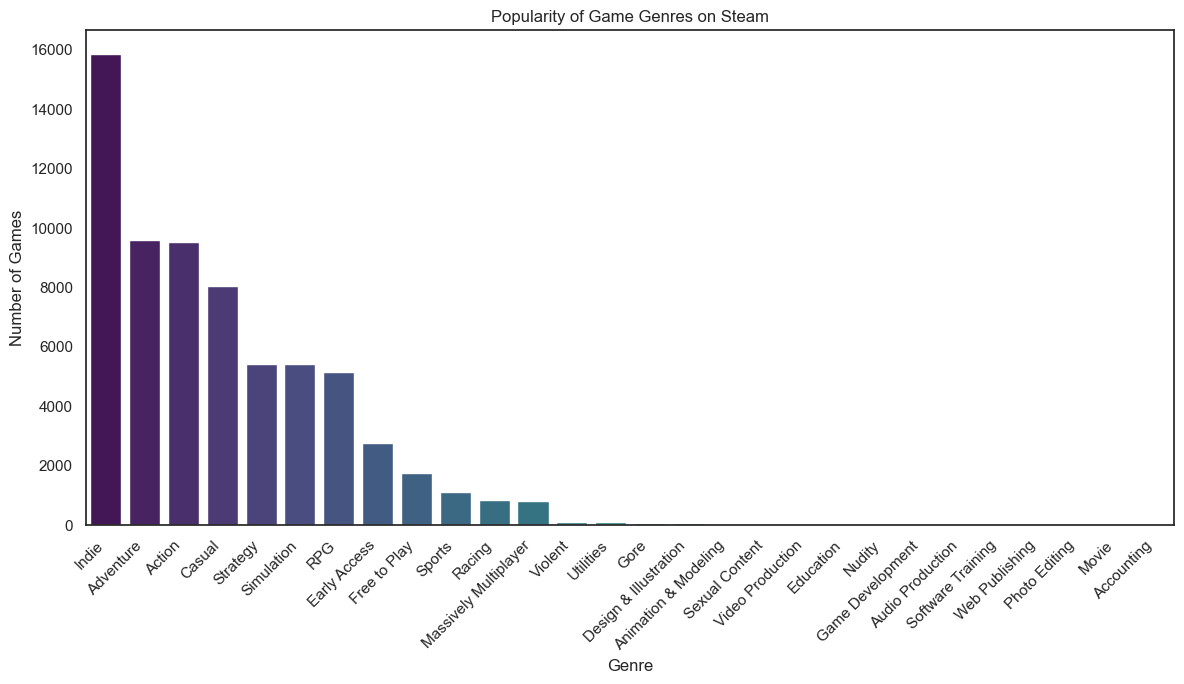

In [11]:
# Set the plot style
sns.set(style="white")

# Create a vertical barplot to visualize the genre popularity
plt.figure(figsize=(12, 7))
sns.barplot(x='genre', y='count', data=genre_popularity, palette='viridis')

# Rotate the x labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Number of Games')
plt.title('Popularity of Game Genres on Steam')

# Disable the grid lines
plt.grid(False)

# Show the plot
plt.tight_layout()  # Ensures everything fits nicely
plt.show()

In [12]:
# Check the column names to verify what they are called
print(games_exploded.columns)

Index(['AppID', 'Name', 'Genres', 'genres_split'], dtype='object')


In [13]:
# MongoDB aggregation pipeline
pipeline = [
    # 1. Split the Genres field by comma
    {
        "$addFields": {
            "Genres_split": { "$split": ["$Genres", ","] }
        }
    },

    # 2. Unwind the split Genres field (explode the array into individual genres)
    {"$unwind": "$Genres_split"},

    # 3. Trim any whitespace around the genre names
    {
        "$addFields": {
            "Genres_split": { "$trim": { "input": "$Genres_split" } }
        }
    },

    # 4. Group by each genre and calculate the average of positive_ratings, negative_ratings, and average_playtime
    {
        "$group": {
            "_id": "$Genres_split",
            "avg_positive_ratings": {"$avg": "$Positive_ratings"},
            "avg_negative_ratings": {"$avg": "$Negative_ratings"},
            "avg_playtime": {"$avg": "$Average_playtime"}
        }
    },

    # 5. Sort by avg_positive_ratings in descending order (optional)
    {"$sort": {"avg_positive_ratings": -1}}
]

# Execute the aggregation pipeline
genre_aggregates = list(collection.aggregate(pipeline))

# Display the result
for genre in genre_aggregates:
    print(f"Genre: {genre['_id']}")
    print(f"  Average Positive Ratings: {genre['avg_positive_ratings']}")
    print(f"  Average Negative Ratings: {genre['avg_negative_ratings']}")
    print(f"  Average Playtime: {genre['avg_playtime']}\n")

Genre: Massively Multiplayer
  Average Positive Ratings: 7529.6824817518245
  Average Negative Ratings: 3040.338199513382
  Average Playtime: 754.8917274939173

Genre: Free to Play
  Average Positive Ratings: 4751.184764070495
  Average Negative Ratings: 1486.3229107447414
  Average Playtime: 536.757816941444

Genre: Action
  Average Positive Ratings: 3623.5490175475466
  Average Negative Ratings: 760.9625932541767
  Average Playtime: 300.62950509614376

Genre: RPG
  Average Positive Ratings: 2736.1877788554802
  Average Negative Ratings: 527.5881668283221
  Average Playtime: 427.1941804073715

Genre: Adventure
  Average Positive Ratings: 2473.045994993742
  Average Negative Ratings: 526.2689820609095
  Average Playtime: 289.3582603254068

Genre: Racing
  Average Positive Ratings: 2416.1169451073984
  Average Negative Ratings: 386.73389021479716
  Average Playtime: 326.8842482100239

Genre: Simulation
  Average Positive Ratings: 2197.423325336778
  Average Negative Ratings: 362.6054622

In [14]:
# Convert the result to a Pandas DataFrame for easier manipulation and plotting
df = pd.DataFrame(genre_aggregates)

# Inspect the columns and first few rows of the DataFrame
print(df.head())
print(df.columns)

                     _id  avg_positive_ratings  avg_negative_ratings  \
0  Massively Multiplayer           7529.682482           3040.338200   
1           Free to Play           4751.184764           1486.322911   
2                 Action           3623.549018            760.962593   
3                    RPG           2736.187779            527.588167   
4              Adventure           2473.045995            526.268982   

   avg_playtime  
0    754.891727  
1    536.757817  
2    300.629505  
3    427.194180  
4    289.358260  
Index(['_id', 'avg_positive_ratings', 'avg_negative_ratings', 'avg_playtime'], dtype='object')


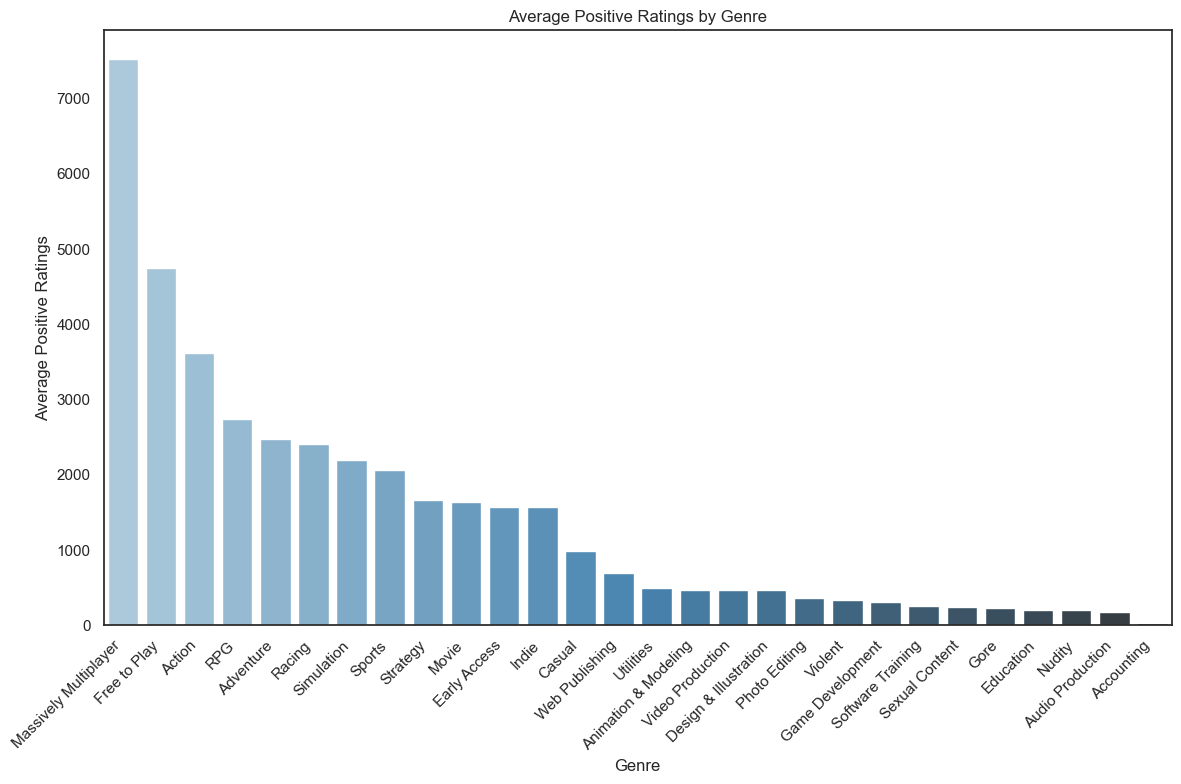

In [15]:
# Rename the '_id' column to 'genre' for clarity
df = df.rename(columns={'_id': 'genre'})

# Plot the average positive ratings by genre
plt.figure(figsize=(12, 8))
sns.barplot(x='genre', y='avg_positive_ratings', data=df, palette='Blues_d')

# Rotate the x labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Average Positive Ratings')
plt.title('Average Positive Ratings by Genre')

# Show the plot
plt.tight_layout()
plt.show()

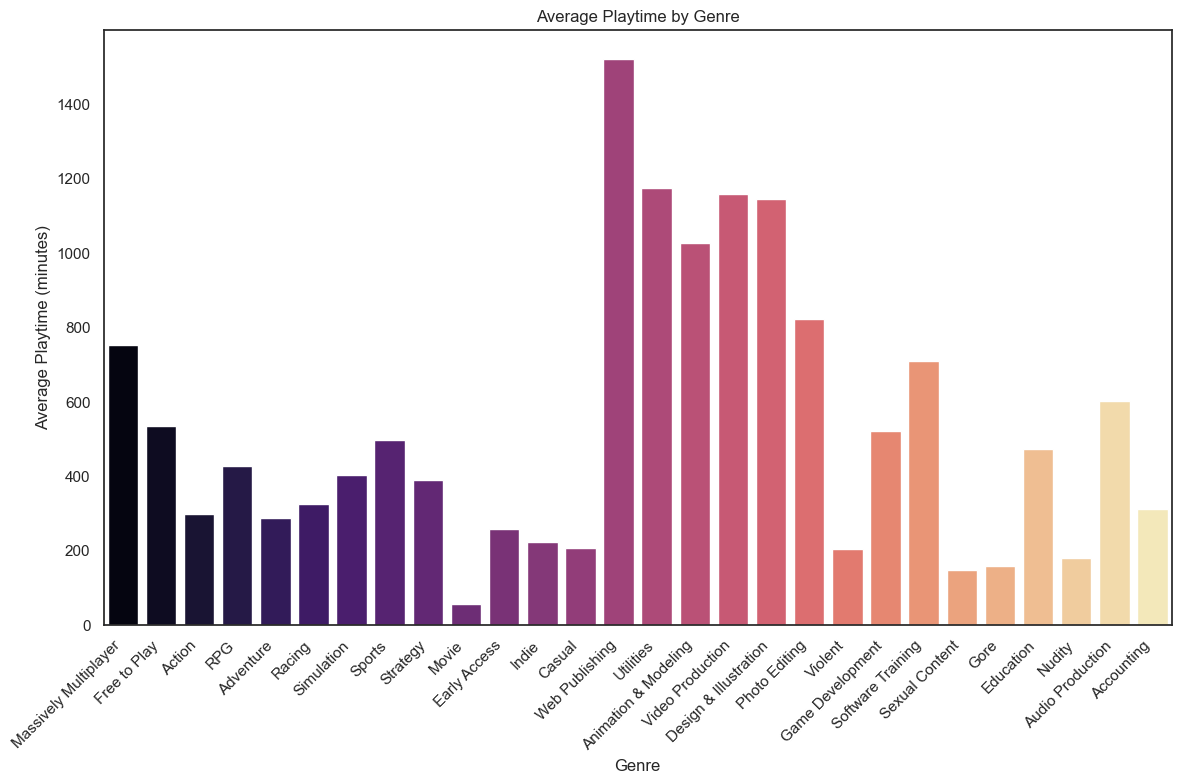

In [16]:
# Plot the average playtime by genre
plt.figure(figsize=(12, 8))
sns.barplot(x='genre', y='avg_playtime', data=df, palette='magma')

# Rotate the x labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Average Playtime (minutes)')
plt.title('Average Playtime by Genre')

# Show the plot
plt.tight_layout()
plt.show()

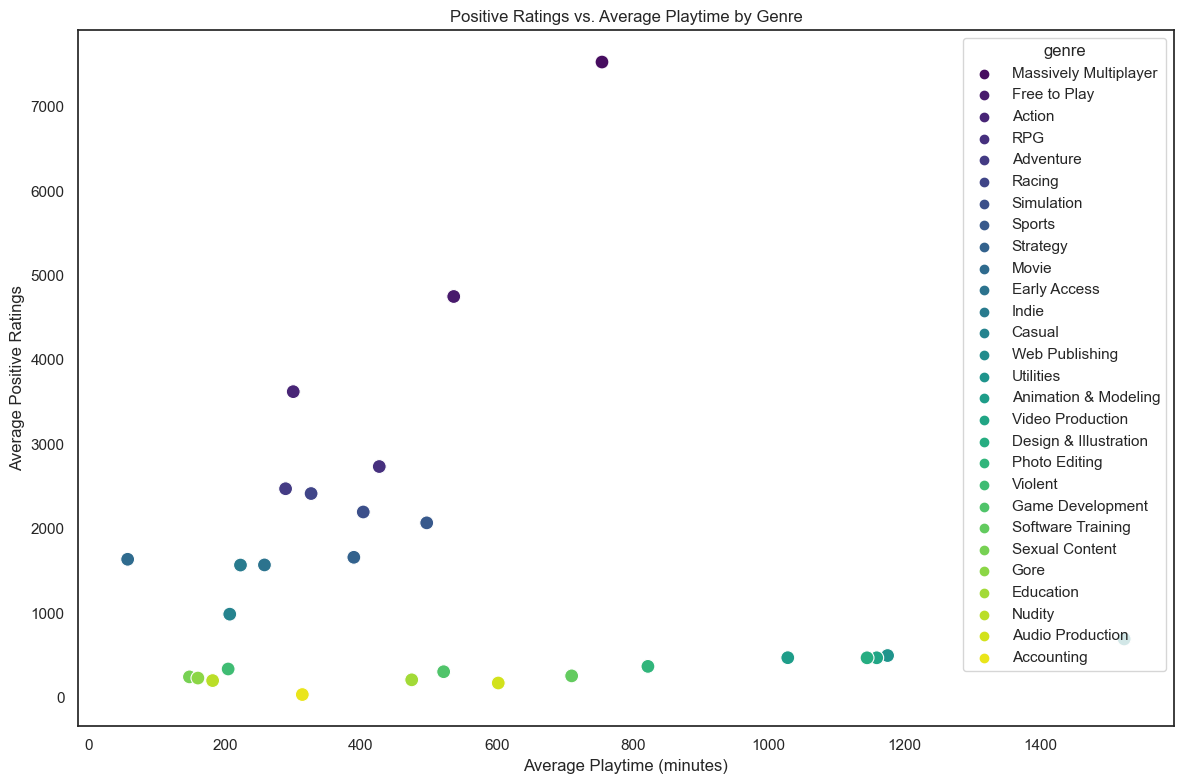

In [17]:
# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='avg_playtime', y='avg_positive_ratings', data=df, hue='genre', palette='viridis', s=100)

# Add labels and title
plt.xlabel('Average Playtime (minutes)')
plt.ylabel('Average Positive Ratings')
plt.title('Positive Ratings vs. Average Playtime by Genre')

# Show the plot
plt.tight_layout()
plt.show()

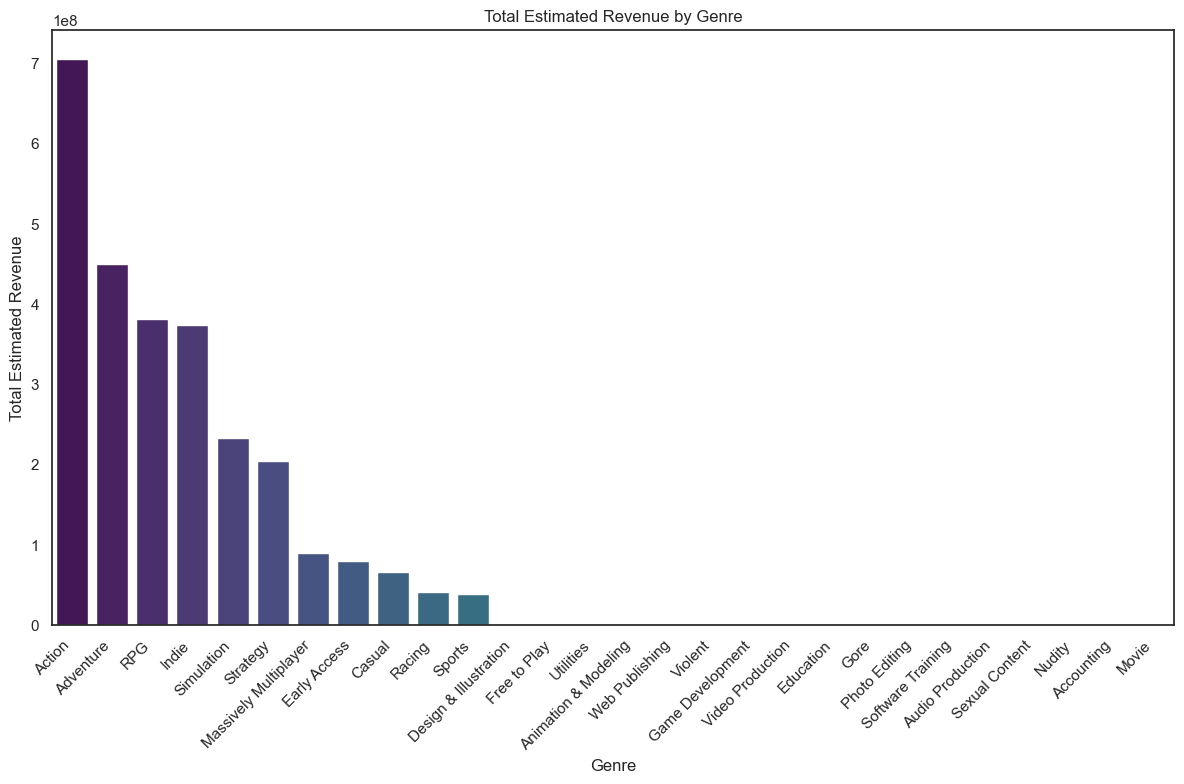

In [41]:
# Fetch the relevant data including price and positive ratings
games_data = pd.DataFrame(list(collection.find({}, {'Genres': 1, 'Price': 1, 'Positive_ratings': 1, '_id': 0})))

# Create a new column 'estimated_revenue' by multiplying Price with Positive_ratings
games_data['estimated_revenue'] = games_data['Price'] * games_data['Positive_ratings']

# Group by genre and sum the estimated revenue
genre_revenue = games_exploded.groupby('genres_split')['estimated_revenue'].sum().reset_index()

# Rename columns for clarity
genre_revenue.columns = ['genre', 'total_estimated_revenue']

# Sort the genres by estimated revenue for better visualization
genre_revenue = genre_revenue.sort_values(by='total_estimated_revenue', ascending=False)

# Plot the total estimated revenue by genre
plt.figure(figsize=(12, 8))
sns.barplot(x='genre', y='total_estimated_revenue', data=genre_revenue, palette='viridis')

# Rotate the x labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Total Estimated Revenue')
plt.title('Total Estimated Revenue by Genre')

# Show the plot
plt.tight_layout()
plt.show()

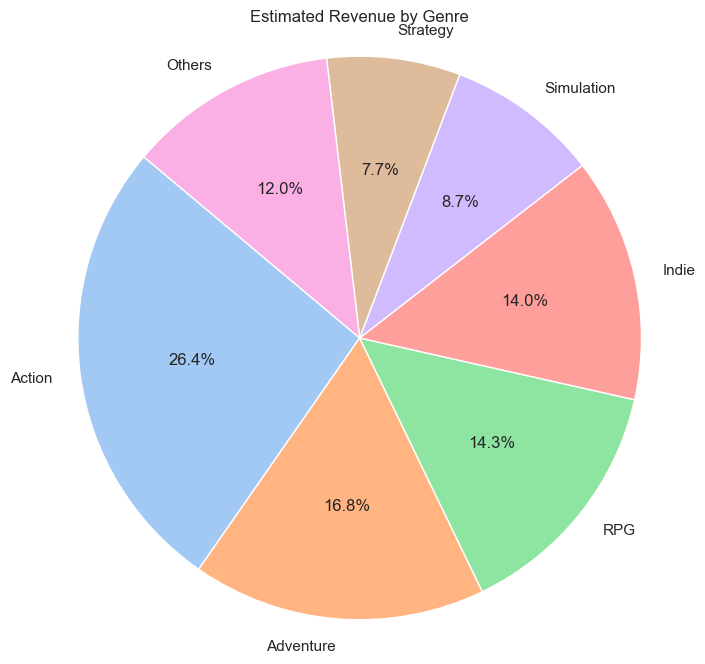

In [43]:
#Define a threshold below which genres will be grouped as "Others"
threshold = 0.05 * genre_revenue['total_estimated_revenue'].sum()  # 5% of total revenue

# Separate smaller genres from larger ones
large_genres = genre_revenue[genre_revenue['total_estimated_revenue'] >= threshold]
small_genres = genre_revenue[genre_revenue['total_estimated_revenue'] < threshold]

# Calculate the "Others" category by summing up smaller genres
others = pd.DataFrame({
    'genre': ['Others'],
    'total_estimated_revenue': [small_genres['total_estimated_revenue'].sum()]
})

# Combine large genres and the "Others" category
final_genre_revenue = pd.concat([large_genres, others])

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(final_genre_revenue['total_estimated_revenue'], labels=final_genre_revenue['genre'], 
        autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Add a title
plt.title('Estimated Revenue by Genre')

# Show the pie chart
plt.show()